In [169]:
# Pandas, package for general data analysis
import pandas as pd
# Factor_Analyzer, for factor analysis functions
from factor_analyzer import FactorAnalyzer
# Matplotlib, for base and adjustable python plotting
import matplotlib.pyplot as plt
# Seaborn, for more specific graphs
import seaborn as sns
# Numpy, for correlation and other mathematical functions
import numpy as np
# Netowrkx, for network relationship graphs
import networkx as nx

parlimentary_results = pd.read_csv("files/parlimentary_results_total.csv", encoding='latin-1')
urbanization = pd.read_csv("files/urbanization.csv", encoding='latin-1')


In [170]:

display(parlimentary_results)


# ### NA Adjustments
# # Dropping all rows with NA values
# p_no_na = parlimentary_results.dropna()

# # Noting the differences in NA values
# print("Differences in NA values for original dataframe:")
# print("Number of rows in original DataFrame:", parlimentary_results.shape[0])
# print("Number of rows after dropping NA values:", p_no_na.shape[0])

# # Displaying only the rows with NA values to determine what is causing the NA values
# p_with_na = parlimentary_results[parlimentary_results.isna().any(axis=1)]
# print("\nRows with NA values:")
# display(p_with_na)

# # Dropping social_support, freedom, generosity, and cpi columns from global_development, and preforming NA dropping again
# p_adj = parlimentary_results.drop(["social_support", "freedom", "generosity", "cpi"], axis=1)
# p_adj_no_na = p_adj.dropna()

# # Noting the new differences in NA values
# print("Differences in NA values after dropping social_support, freedom, generosity, and cpi:")
# print("Number of rows in original DataFrame:", p_adj.shape[0])
# print("Number of rows after dropping NA values:", p_adj_no_na.shape[0])

# ### Changing to continuous
# # Adjusting the dataset so that it only has continuous values. Grabs all the indexes that match the selected dtypes from the original dataframe.
# p_continuous = p_adj_no_na[p_adj_no_na.select_dtypes(include=["float64", "int64"]).columns].dropna()
# p_string = p_adj_no_na[p_adj_no_na.select_dtypes(include=["object"]).columns]

,Year,Sex,Party,Constituency and municipality in the election year,Votes cast (number)
0,1983,Total,KOK,KU091 Helsinki,90913
1,1983,Total,KOK,KU018 Askola,639
2,1983,Total,KOK,KU049 Espoo,30880
3,1983,Total,KOK,KU078 Hanko,566
4,1983,Total,KOK,KU092 Vantaa,20040
...,...,...,...,...,...
213318,2023,Total,Others,KU478 Maarianhamina,5175
213319,2023,Total,Others,KU736 Saltvik,736
213320,2023,Total,Others,KU766 Sottunga,55
213321,2023,Total,Others,KU771 Sund,474


In [171]:
import re

# Read the CSV file
parlimentary_results_mod = parlimentary_results.copy(deep=True)
# Clean up column names (remove extra spaces)
parlimentary_results_mod.columns = parlimentary_results_mod.columns.str.strip()

# Year Thresh
YEAR_THRESHOLD = 1800

original_rows = len(parlimentary_results_mod)
parlimentary_results_mod = parlimentary_results_mod[parlimentary_results_mod['Year'] >= YEAR_THRESHOLD]
filtered_rows = len(parlimentary_results_mod)

print(f"\nYear threshold set to: {YEAR_THRESHOLD}")
print(f"Rows before year filter: {original_rows:,}")
print(f"Rows after year filter: {filtered_rows:,}")
print(f"Rows dropped: {original_rows - filtered_rows:,}")


# Extract the KU code from the constituency column
# Pattern matches KU followed by digits at the start of the string
parlimentary_results_mod['KU_Code'] = parlimentary_results_mod['Constituency and municipality in the election year'].str.extract(r'^(KU\d+)')

# Extract the municipality name (everything after the KU code)
parlimentary_results_mod['Municipality'] = parlimentary_results_mod['Constituency and municipality in the election year'].str.replace(r'^KU\d+\s*', '', regex=True)
urban_dict = urbanization.set_index('Area')['Degree of urbanisation, %'].to_dict()
parlimentary_results_mod['Degree of urbanisation, %'] = parlimentary_results_mod['Municipality'].map(urban_dict)


# Handle the "." values in Votes cast - convert to 0
parlimentary_results_mod['Votes cast (number)'] = parlimentary_results_mod['Votes cast (number)'].replace('.', '0')
parlimentary_results_mod['Votes cast (number)'] = pd.to_numeric(parlimentary_results_mod['Votes cast (number)'], errors='coerce').fillna(0).astype(int)

# Create the constituency_year column
parlimentary_results_mod['Constituency_Year'] = parlimentary_results_mod['Municipality'] + '_' + parlimentary_results_mod['Year'].astype(str)
urban_dict = parlimentary_results_mod.set_index('Constituency_Year')['Degree of urbanisation, %'].to_dict()


# Group by KU_Code, Constituency_Year, Year, Municipality, and Party, summing votes
# This handles any duplicates within the same KU code
grouped = parlimentary_results_mod.groupby(['KU_Code', 'Municipality', 'Year', 'Party'])['Votes cast (number)'].sum().reset_index()

# Create the final constituency_year column for pivoting
grouped['Constituency_Year'] = grouped['Municipality'] + '_' + grouped['Year'].astype(str)

# Pivot the data: rows are constituency_year, columns are parties
pivot_df = grouped.pivot_table(
    index='Constituency_Year',
    columns='Party',
    values='Votes cast (number)',
    aggfunc='sum',
    fill_value=0
)

# Reset index to make Constituency_Year a regular column
pivot_df = pivot_df.reset_index()

# Sort by constituency name and year for better readability
pivot_df = pivot_df.sort_values('Constituency_Year')
print(len(pivot_df))

# Drop rows where the sum of all party votes is less than 500
# Calculate row sum excluding the Constituency_Year column
party_columns = [col for col in pivot_df.columns if col != 'Constituency_Year']
pivot_df['row_sum'] = pivot_df[party_columns].sum(axis=1)
pivot_df = pivot_df[pivot_df['row_sum'] >= 500]
pivot_df = pivot_df.drop('row_sum', axis=1)
# print(pivot_df.columns)
# pivot_df = pivot_df.drop(columns=["KA (2015)", "Change2011 (2015)", "SSP (2011)", "STL (2019)", "STP (2015)", "SVR (2011)", "KIPU (2003)"])
# print(len(pivot_df))

print("\n" + "="*60)
print("COLUMN SUMS (Total votes by party across all constituencies):")
print("="*60)
column_sums = pivot_df[party_columns].sum().sort_values(ascending=False)
for party, total in column_sums.items():
    print(f"{party}: {total:,}")
print("="*60)


# Set threshold for minimum total votes per party
PARTY_THRESHOLD = 50000  # Adjust this value as needed

# Filter out party columns below threshold
parties_to_keep = column_sums[column_sums >= PARTY_THRESHOLD].index.tolist()
parties_dropped = column_sums[column_sums < PARTY_THRESHOLD].index.tolist()

print(f"\nParty threshold set to: {PARTY_THRESHOLD:,}")
print(f"Parties kept: {len(parties_to_keep)}")
print(f"Parties dropped: {len(parties_dropped)}")
if parties_dropped:
    print(f"Dropped parties: {', '.join(parties_dropped)}")

pivot_df = pivot_df[['Constituency_Year'] + parties_to_keep]
# pivot_df = pivot_df.drop(columns=["Others", "Other party"])


# # Save to CSV
pivot_df.to_csv('output.csv', index=False)

p_continuous = pivot_df[pivot_df.select_dtypes(include=["float64", "int64"]).columns]

# print("Transformation complete! Output saved to 'output.csv'")
# print(f"\nOutput shape: {pivot_df.shape}")
# print(f"\nFirst few rows:")
# print(pivot_df[260:280])
display(pivot_df)
display(parlimentary_results_mod)


Year threshold set to: 1800
Rows before year filter: 213,323
Rows after year filter: 213,323
Rows dropped: 0
5203

COLUMN SUMS (Total votes by party across all constituencies):
SDP: 6,967,618
KOK: 6,342,911
KESK: 6,043,021
PS: 3,062,174
VAS: 2,980,593
VIHR: 2,171,452
RKP: 1,507,965
KD: 1,198,066
Others: 301,824
Other party: 143,652
SKS (2007): 114,250
SKP: 83,878
LIB (2007): 82,048
LIIKE: 74,992
KaL: 74,522
Pirate Pty: 62,278
SEP (1999): 53,991
SSP (2011): 40,998
KL: 31,302
KIPU (2003): 28,624
REM (1999): 28,537
VL: 27,552
KTP (2019): 23,016
POP (1991): 21,526
LIBE: 19,996
Change2011 (2015): 14,944
STL (2019): 11,365
LLP (1999): 10,637
VKK: 8,467
FP: 7,775
KP (2019): 7,644
EOP: 6,485
SIK (2007): 6,244
KA (2015): 5,927
YVP (2007): 5,023
KRIP: 4,894
STP (2015): 4,600
SVR (2011): 4,284
SKE: 3,591
SML: 2,306
AP: 985

Party threshold set to: 50,000
Parties kept: 17
Parties dropped: 24
Dropped parties: SSP (2011), KL, KIPU (2003), REM (1999), VL, KTP (2019), POP (1991), LIBE, Change2011 (20

Party,Constituency_Year,SDP,KOK,KESK,PS,VAS,VIHR,RKP,KD,Others,Other party,SKS (2007),SKP,LIB (2007),LIIKE,KaL,Pirate Pty,SEP (1999)
6,Akaa_2007,2304,1839,789,269,586,401,0,522,0,0,3,65,22,0,12,0,0
7,Akaa_2011,2372,1874,778,2089,794,406,0,370,0,0,0,35,0,0,5,43,0
8,Akaa_2015,2214,1455,1248,1935,620,693,0,404,41,0,0,18,0,0,41,58,0
9,Akaa_2019,2537,1486,676,1780,671,708,7,414,197,0,0,19,0,0,23,23,0
10,Akaa_2023,2611,1700,648,2289,468,409,10,435,2,0,0,16,0,260,1,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5198,Äänekoski_2007,3550,813,2736,282,1319,321,0,1100,0,0,0,65,7,0,15,0,0
5199,Äänekoski_2011,2678,953,1755,2112,1833,312,0,887,0,0,0,26,0,0,9,44,0
5200,Äänekoski_2015,2405,750,2215,2785,1429,373,0,468,14,0,0,26,0,0,22,25,0
5201,Äänekoski_2019,1919,954,1531,1942,2208,623,0,567,108,0,0,6,0,0,0,35,0


,Year,Sex,Party,Constituency and municipality in the election year,Votes cast (number),KU_Code,Municipality,"Degree of urbanisation, %",Constituency_Year
0,1983,Total,KOK,KU091 Helsinki,90913,KU091,Helsinki,99.9,Helsinki_1983
1,1983,Total,KOK,KU018 Askola,639,KU018,Askola,54.1,Askola_1983
2,1983,Total,KOK,KU049 Espoo,30880,KU049,Espoo,99.5,Espoo_1983
3,1983,Total,KOK,KU078 Hanko,566,KU078,Hanko,95.4,Hanko_1983
4,1983,Total,KOK,KU092 Vantaa,20040,KU092,Vantaa,99.8,Vantaa_1983
...,...,...,...,...,...,...,...,...,...
213318,2023,Total,Others,KU478 Maarianhamina,5175,KU478,Maarianhamina,NaN,Maarianhamina_2023
213319,2023,Total,Others,KU736 Saltvik,736,KU736,Saltvik,50.4,Saltvik_2023
213320,2023,Total,Others,KU766 Sottunga,55,KU766,Sottunga,0.0,Sottunga_2023
213321,2023,Total,Others,KU771 Sund,474,KU771,Sund,0.0,Sund_2023


c:\Users\kaife\Documents\Git\SDPAnalysis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kaife\Documents\Git\SDPAnalysis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[[ 0.02840851 -0.02925867  0.06010839]
 [ 0.22957841 -0.14250415 -0.30257973]
 [ 0.22029088 -0.19772382 -0.00575903]
 ...
 [ 0.28198147 -0.27240672 -0.31902914]
 [ 0.30092572 -0.27186492 -0.3861757 ]
 [ 0.1585796  -0.18072755 -0.33495958]]


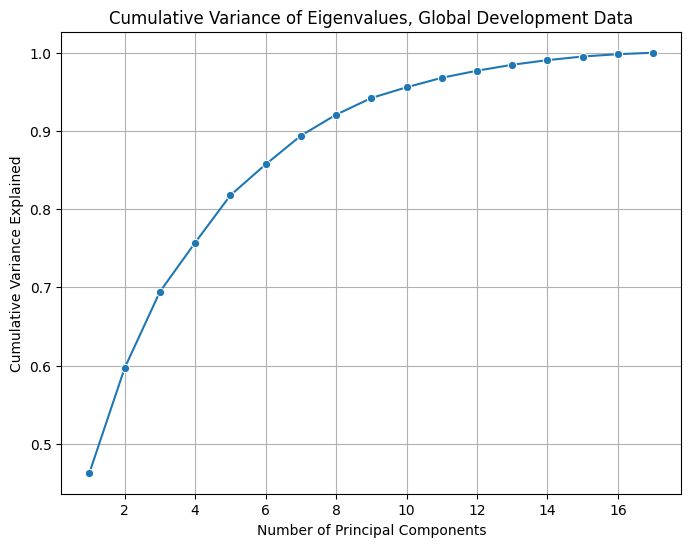

In [172]:


# Initialize FactorAnalyzer object with oblique rotation
p_fa_4_oblique = FactorAnalyzer(n_factors=3, rotation='oblimin')

# Fit the factor analysis model to DataFrame
p_fa_4_oblique.fit(p_continuous)

### Creating Factor Analysis Diagram
# Finding loadings
p_factor_loadings = p_fa_4_oblique.loadings_
p_factor_names = [f"Factor {i+1}" for i in range(p_fa_4_oblique.n_factors)]
p_factor_scores = p_fa_4_oblique.transform(p_continuous)
print(p_factor_scores)


# Getting eigenvalues
p_eigenvalues = p_fa_4_oblique.get_eigenvalues()[0]

### Cumulative variance plot
# Determining the explained variance per eigenvalue, and its cumulative effect.
explained_variance_ratio = p_eigenvalues / np.sum(p_eigenvalues)
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Creating the cumulative variance plot
plt.figure(figsize=(8, 6))
sns.lineplot(x=np.arange(1, len(cumulative_variance_ratio) + 1), y=cumulative_variance_ratio, marker='o')
plt.title('Cumulative Variance of Eigenvalues, Global Development Data')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

0       0.019753
1      -0.071835
2       0.005603
3      -0.020039
4      -0.107528
          ...   
4248    0.044654
4249   -0.080224
4250   -0.103151
4251   -0.119038
4252   -0.119036
Length: 4253, dtype: float64


c:\Users\kaife\Documents\Git\SDPAnalysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


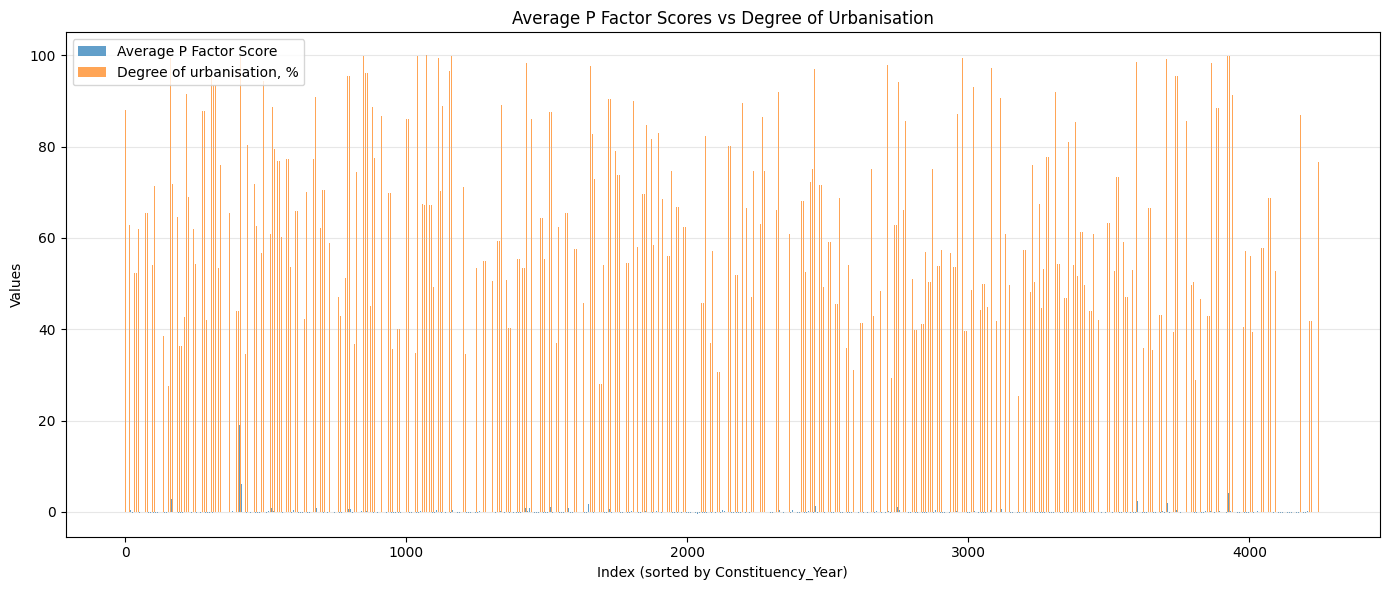

In [173]:
import matplotlib.pyplot as plt

# Sort parlimentary_results_mod by Constituency_Year
pivot_df['Degree of urbanisation, %'] = pivot_df['Constituency_Year'].map(urban_dict)

p_scores = pd.DataFrame(p_factor_scores)
# p_scores = pd.concat(p_scores, parlimentary_results_mod_sorted["Degree of urbanisation, %"])


# Calculate the mean of the three factors for each row
p_factor_mean = p_scores.mean(axis=1)
print(p_factor_mean)

# Create bar plot
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(p_factor_mean))
width = 0.35

bars1 = ax.bar(x - width/2, p_factor_mean.values, width, 
               label='Average P Factor Score', alpha=0.7, color='tab:blue')
bars2 = ax.bar(x + width/2, pivot_df['Degree of urbanisation, %'], 
               width, label='Degree of urbanisation, %', alpha=0.7, color='tab:orange')

ax.set_xlabel('Index (sorted by Constituency_Year)')
ax.set_ylabel('Values')
ax.set_title('Average P Factor Scores vs Degree of Urbanisation')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

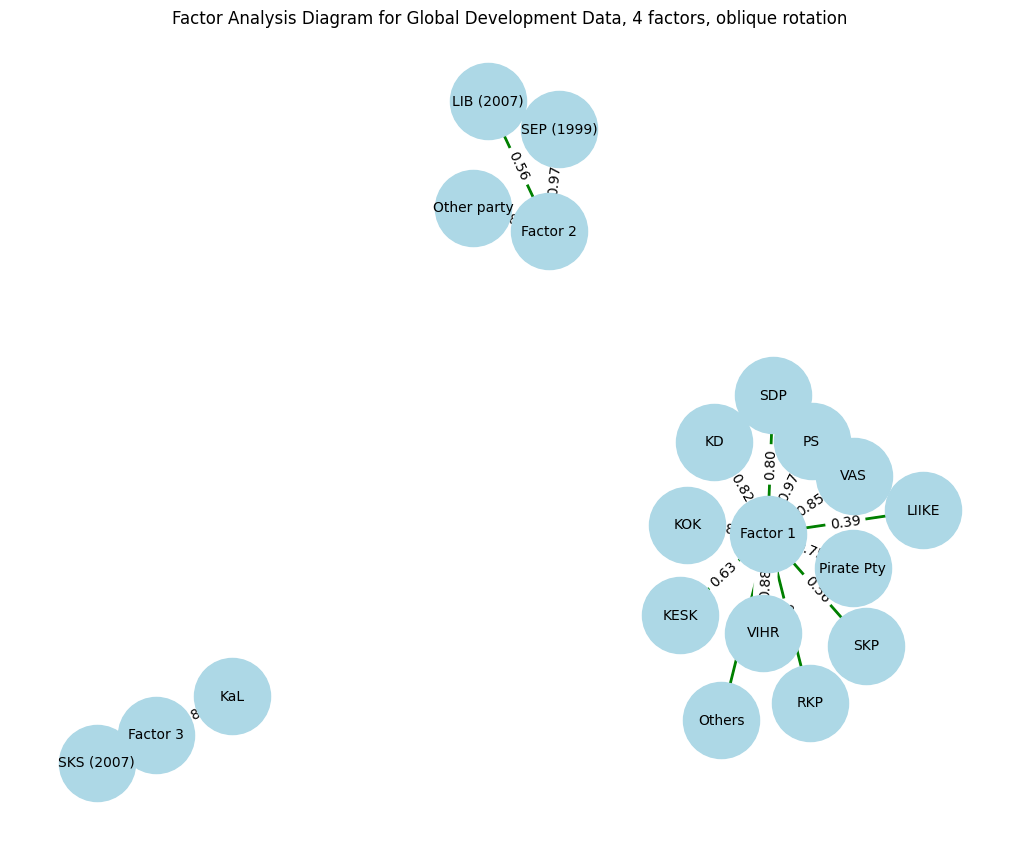

In [174]:
G = nx.Graph()

# Adding nodes for factors
for i, factor_name in enumerate(p_factor_names):
    G.add_node(factor_name)

# Adding edges between factors based on factor loadings
for i in range(p_fa_4_oblique.n_factors):
    for j in range(p_fa_4_oblique.n_factors):
        if i != j:
            weight = np.corrcoef(p_factor_loadings[:, i], p_factor_loadings[:, j])[0, 1]
            if abs(weight) > 0.6:  # Weight threshold
                G.add_edge(p_factor_names[i], p_factor_names[j], weight=weight)

# Adding nodes for variables and edges between variables and factors
for j, variable in enumerate(p_continuous.columns):
    for i, factor_name in enumerate(p_factor_names):
        weight = p_factor_loadings[j, i]
        if abs(weight) > 0.3:  # Weight threshold
            G.add_node(variable)
            G.add_edge(variable, factor_name, weight=weight)

# Defining specific factor positions (had to be manual, else graph splays information with current settings for negative values.) Done after the graph was developed.
p_factor_positions = {
    p_factor_names[0]: (5, 0),
    p_factor_names[1]: (0, 5)
    # p_factor_names[2]: (5, 5)
    # p_factor_names[3]: (0, 0)
}

# Creating separate lists of edges for positive and negative values
positive_edges = [(u, v) for u, v, w in G.edges(data='weight') if w > 0]
negative_edges = [(u, v) for u, v, w in G.edges(data='weight') if w < 0]

# Drawing the graph with different edge colors for positive and negative values
plt.figure(figsize=(10, 8))  # Adjust the figsize as needed
pos = nx.spring_layout(G, pos=p_factor_positions, fixed=p_factor_positions.keys())
nx.draw(G, pos, with_labels=True, node_size=3000, font_size=10, node_color='lightblue')

# Drawing positive edges in green and negative edges in red
nx.draw_networkx_edges(G, pos, edgelist=positive_edges, edge_color='g', width=2)
nx.draw_networkx_edges(G, pos, edgelist=negative_edges, edge_color='r', width=2)

# Creating edge labels
edge_labels = {(u, v): f"{w:.2f}" for u, v, w in G.edges(data='weight')}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Factor Analysis Diagram for Global Development Data, 4 factors, oblique rotation')
plt.show()

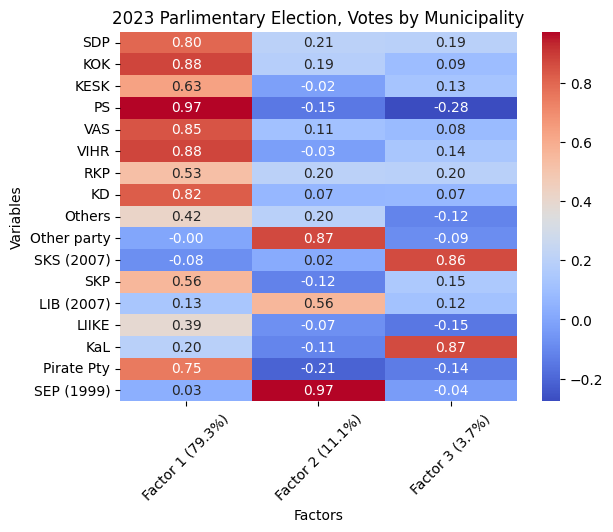

In [175]:
# Create the heatmap with variable names


# Factor 1
p_factor_names[0] = "Factor 1 (79.3%)"

# Factor 2
p_factor_names[1] = "Factor 2 (11.1%)"

# Factor 3
p_factor_names[2] = "Factor 3 (3.7%)"


sns.heatmap(p_factor_loadings, cmap='coolwarm', annot=True, fmt='.2f', yticklabels=p_continuous.columns, xticklabels=p_factor_names)
plt.title('2023 Parlimentary Election, Votes by Municipality')
plt.xlabel('Factors')
plt.ylabel('Variables')
plt.xticks(rotation=45) # Rotates the x-axis labels to ensure they are readable/do not blend into one another
plt.show()

In [176]:
from scipy.stats import pearsonr
import numpy as np
from sklearn.linear_model import LinearRegression

# Example: partial correlation between two variables from your original data
var_A = p_continuous['SDP']
var_B = p_continuous['VAS']

# Get residuals after removing factor effects
model_A = LinearRegression().fit(p_factor_scores, var_A)
residuals_A = var_A - model_A.predict(p_factor_scores)

model_B = LinearRegression().fit(p_factor_scores, var_B)
residuals_B = var_B - model_B.predict(p_factor_scores)

# Correlation of residuals = partial correlation
partial_corr, p_value = pearsonr(
    residuals_A, residuals_B)
print(f"Partial correlation (controlling for 4 factors): {partial_corr:.3f}")
print(f"P-value: {p_value:.3f}")

# Compare to simple correlation (no controls)
simple_corr, _ = pearsonr(var_A, var_B)
print(f"Simple correlation (no controls): {simple_corr:.3f}")

Partial correlation (controlling for 4 factors): 0.308
P-value: 0.000
Simple correlation (no controls): 0.900
